#Importing Dataset

In [235]:
#dataset @ https://finance.yahoo.com/quote/MSFT/history

In [236]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [237]:
df=pd.read_csv("/content/MSFT.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060396,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062553,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063632,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062014,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.060936,47894400
...,...,...,...,...,...,...,...
9456,2023-09-20,329.510010,329.589996,320.510010,320.769989,320.769989,21436500
9457,2023-09-21,319.260010,325.350006,315.000000,319.529999,319.529999,35529500
9458,2023-09-22,321.320007,321.450012,316.149994,317.010010,317.010010,21429700
9459,2023-09-25,316.589996,317.670013,315.000000,317.540009,317.540009,17836000


#Cleaning the Dataset

In [238]:
df1=df[['Close']]
df1.shape

(9461, 1)

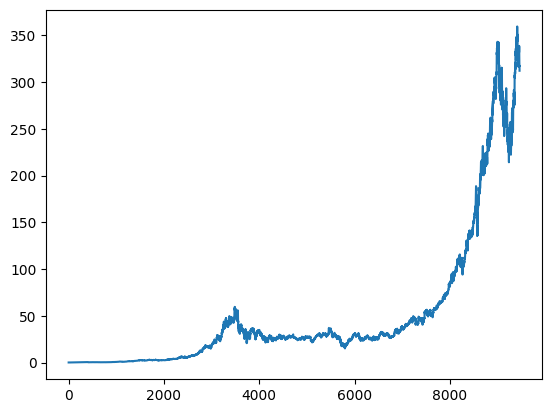

In [239]:
plt.plot(df1.Close)

#Scaling the Dataset using MinMaxScaler

In [240]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(df1)
df1.shape

(9461, 1)

#Train Test Split

In [241]:
train_size=int(len(df1)*0.8)
test_size=int(len(df1)-train_size)

train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:1]

train_data,test_data

(array([[1.93211062e-05],
        [2.89816593e-05],
        [3.38147182e-05],
        ...,
        [1.50973187e-01],
        [1.51835742e-01],
        [1.48580319e-01]]),
 array([[0.14960981],
        [0.15019412],
        [0.14991588],
        ...,
        [0.88180297],
        [0.88327764],
        [0.86825261]]))

In [242]:
train_size,test_size

(7568, 1893)

In [243]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [244]:
time_step = 100
x_train, y_train = create_dataset(train_data,time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [245]:
x_train.shape,x_test.shape

((7467, 100), (1792, 100))

#Stacked LSTM model

In [246]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [247]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [248]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error')

In [249]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_21 (LSTM)              (None, 100, 50)           10400     
                                                                 
 lstm_22 (LSTM)              (None, 100, 50)           20200     
                                                                 
 lstm_23 (LSTM)              (None, 50)                20200     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [250]:
model.fit(x_train,y_train)

234/234 [==============================] - 37s 133ms/step - loss: 3.1843e-04


In [251]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

56/56 [==============================] - 3s 51ms/step


In [252]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [253]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))
math.sqrt(mean_squared_error(y_test,test_predict))

153.05266236820694

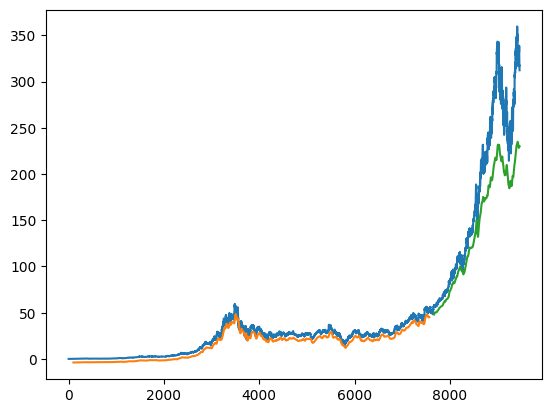

In [254]:
look_back=100

train_predict_plot=np.empty_like(df1)
train_predict_plot[:,:]=np.nan
train_predict_plot[look_back:len(train_predict)+look_back,:]=train_predict

test_predict_plot=np.empty_like(df1)
test_predict_plot[:,:]=np.nan
test_predict_plot[len(train_predict)+(look_back*2)+1:len(df1)-1, :]=test_predict

plt.plot(scaler.inverse_transform(df1))
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()




#Forecasting

In [255]:
len(test_data)

1893

In [256]:
x_input=test_data[1793:].reshape(1,-1)
x_input.shape

(1, 100)

In [257]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.8495269078011949,
 0.8641067469748,
 0.8585419122428234,
 0.8539509402834469,
 0.8687255709320101,
 0.86260421655541,
 0.8594323052768613,
 0.8607956619620218,
 0.8671395707740578,
 0.8734278618453651,
 0.8860043577330413,
 0.8855035420840849,
 0.8934055990562397,
 0.8769337355506841,
 0.873010515934971,
 0.9065943130193715,
 0.9259877676251449,
 0.9213132396722677,
 0.9134668894781974,
 0.9251251403340023,
 0.9329715767830109,
 0.9344741044199835,
 0.9281858161310937,
 0.8995269506504223,
 0.9047579092105673,
 0.9090150049981119,
 0.9230940285227608,
 0.9298831352430244,
 0.9383694720378629,
 0.968308310720071,
 0.9522537096523884,
 0.9403449661083757,
 0.9278519399592619,
 0.9449637872831684,
 0.9319142442718485,
 0.9140511720832988,
 0.9306622065406662,
 0.934223697986714,
 0.9319977140104108,
 0.9472732437804513,
 0.9401780266312512,
 0.9406232245394788,
 0.9493043528092755,
 0.9380355958660312,
 0.9230383273095111,
 0.9248191133775867,
 0.9379799781253025,
 0.9531719546842597,


In [258]:
lst_output=[]
n_steps=100
i=0

while(i<100):
    if(len(temp_input)>100):
      x_input=np.array(temp_input[1:])
      x_input=x_input.reshape(1,-1)
      x_input=x_input.reshape((1,n_steps,1))

      y_output=model.predict(x_input)
      temp_input.extend(y_output[0].tolist())
      temp_input=temp_input[1:]
      lst_output.extend(y_output.tolist())
      i+=1

    else:
      x_input=x_input.reshape((1,n_steps,1))
      y_output=model.predict(x_input)
      temp_input.extend(y_output[0].tolist())
      lst_output.extend(y_output.tolist())
      i+=1

print(lst_output)

1/1 [==============================] - 0s 31ms/step
[[0.6390801668167114], [0.6375622749328613], [0.6348490118980408], [0.6309184432029724], [0.6258761286735535], [0.6198948621749878], [0.6131719946861267], [0.6059032082557678], [0.5982658267021179], [0.5904113054275513], [0.5824635624885559], [0.574518620967865], [0.5666490197181702], [0.5589058995246887], [0.5513240694999695], [0.543925404548645], [0.5367213487625122], [0.5297167897224426], [0.5229107737541199], [0.5162996649742126], [0.5098775625228882], [0.5036371946334839], [0.4975709915161133], [0.49167105555534363], [0.48592954874038696], [0.4803388714790344], [0.47489234805107117], [0.4695829153060913], [0.46440422534942627], [0.45935067534446716], [0.45441654324531555], [0.449596643447876], [0.44488605856895447], [0.4402802586555481], [0.4357750713825226], [0.4313661754131317], [0.4270496964454651], [0.4228222072124481], [0.4186799228191376], [0.41461995244026184], [0.4106389880180359], [0.40673431754112244], [0.40290281176567

In [259]:
new_day=np.arange(1,101)
new_predict=np.arange(101,201)

In [260]:
len(df1)

9461

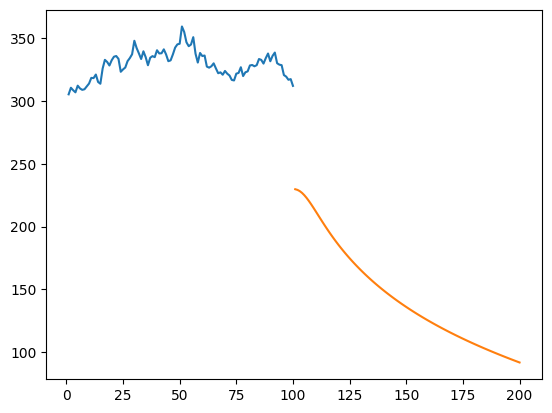

In [261]:
plt.plot(new_day,scaler.inverse_transform(df1[9361:]))
plt.plot(new_predict,scaler.inverse_transform(lst_output))


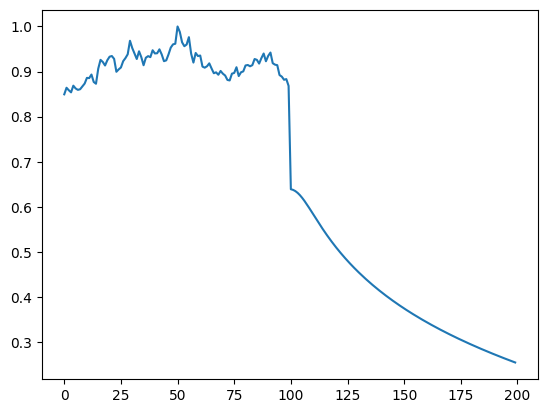

In [262]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[9361:])

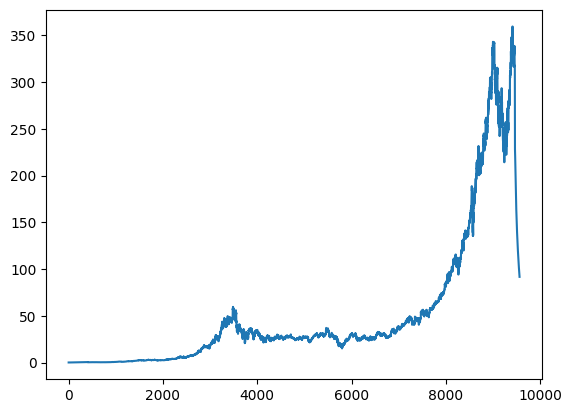

In [263]:
df3=scaler.inverse_transform(df3)
plt.plot(df3)